<h3><a href="https://pollytikhonova.github.io/bioinformatics_homeworks/Medicine_modelling"><img src="https://pollytikhonova.github.io/bioinformatics_homeworks/GitHub-Mark-32px.png" alt="Вернуться в репозиторий" title="Вернуться в репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a>
Tikhonova Polina. Homework 7. </h3>

In [1]:
import numpy as np
import copy

# Отображение структур
import IPython.display
import ipywidgets
from IPython.display import display,display_svg,SVG,Image, HTML

# Open Drug Discovery Toolkit
import oddt
import oddt.docking
import oddt.interactions

# Органика
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pmx # Модуль для манипулирования pdb 

In [2]:
pdb=pmx.Model('with_ligand.B99990001.pdb')

for r in pdb.residues[135:]:
    print r #посмотрим остатки

<Molecule: id = 136 name = LYS chain_id =    natoms = 9>
<Molecule: id = 137 name = ASP chain_id =    natoms = 8>
<Molecule: id = 138 name = LEU chain_id =    natoms = 8>
<Molecule: id = 139 name = SER chain_id =    natoms = 6>
<Molecule: id = 140 name = LYS chain_id =    natoms = 9>
<Molecule: id = 141 name = TYR chain_id =    natoms = 12>
<Molecule: id = 142 name = LEU chain_id =    natoms = 8>
<Molecule: id = 143 name = GLU chain_id =    natoms = 9>
<Molecule: id = 144 name = GLY chain_id =    natoms = 4>
<Molecule: id = 145 name = CYS chain_id =    natoms = 6>
<Molecule: id = 146 name = HIS chain_id =    natoms = 10>
<Molecule: id = 147 name = LEU chain_id =    natoms = 9>
<Molecule: id = 148 name = NAG chain_id =    natoms = 14>
<Molecule: id = 149 name = NAG chain_id =    natoms = 14>
<Molecule: id = 150 name = NDG chain_id =    natoms = 15>


In [3]:
# создание объектов белок и лиганда
newpdb = pdb.copy()
for r in newpdb.residues[-3:]:
    newpdb.remove_residue(r)
lig = pdb.copy()
del lig.residues[:-3]
for a in lig.atoms:
   a.x
display(HTML('<b>New pdb</b>'))
for r in newpdb.residues[135:]:
    print r #посмотрим остатки
    
display(HTML('<b>Ligand</b>'))
for r in lig.residues:
    print r #посмотрим остатки

<Molecule: id = 136 name = LYS chain_id =    natoms = 9>
<Molecule: id = 137 name = ASP chain_id =    natoms = 8>
<Molecule: id = 138 name = LEU chain_id =    natoms = 8>
<Molecule: id = 139 name = SER chain_id =    natoms = 6>
<Molecule: id = 140 name = LYS chain_id =    natoms = 9>
<Molecule: id = 141 name = TYR chain_id =    natoms = 12>
<Molecule: id = 142 name = LEU chain_id =    natoms = 8>
<Molecule: id = 143 name = GLU chain_id =    natoms = 9>
<Molecule: id = 144 name = GLY chain_id =    natoms = 4>
<Molecule: id = 145 name = CYS chain_id =    natoms = 6>
<Molecule: id = 146 name = HIS chain_id =    natoms = 10>
<Molecule: id = 147 name = LEU chain_id =    natoms = 9>


<Molecule: id = 148 name = NAG chain_id =    natoms = 14>
<Molecule: id = 149 name = NAG chain_id =    natoms = 14>
<Molecule: id = 150 name = NDG chain_id =    natoms = 15>


In [4]:
coordinates = [a.x for a in lig.atoms]
center = np.mean(coordinates, axis=0)

In [5]:
newpdb.writePDB('my_prot.pdb')

### Подготовка белка для докинга

In [6]:
prot = oddt.toolkit.readfile('pdb','my_prot.pdb').next()

prot.OBMol.AddPolarHydrogens()
prot.OBMol.AutomaticPartialCharge()

print 'Is it the first mol in 1lmp is protein?',prot.protein,':) and MW of this mol is:', prot.molwt 

Is it the first mol in 1lmp is protein? False :) and MW of this mol is: 16831.041


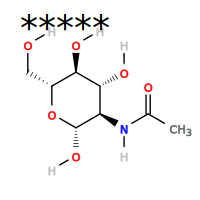

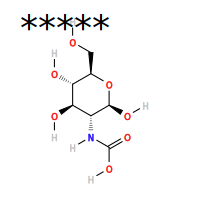

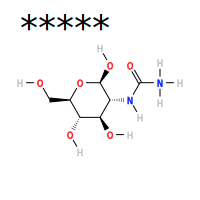

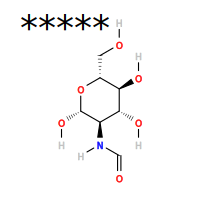

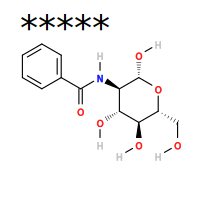

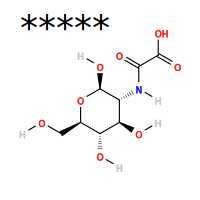

In [7]:
smilesNAG = ['CC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O']
all_smiles = ['CC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',               # original
             'OC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',                # OH       
             '[NH3+]C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',           # NH3+
             'C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',                 # H
             'C2=CC=C(C=C2)C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',    # Ph
             '[O-]C(=O)C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O']        # COO-
mols= []
images =[]

for s in all_smiles:
    m = oddt.toolkit.readstring('smi', s)
    if not m.OBMol.Has3D(): 
        m.make3D(forcefield='mmff94', steps=150)
        m.removeh()
        m.OBMol.AddPolarHydrogens()

    mols.append(m)
    ###with print m.OBMol.Has3D() was found that:
    ### deep copy needed to keep 3D , write svg make mols flat
    images.append((SVG(copy.deepcopy(m).write('svg'))))

display_svg(*images)

### Докинг

In [8]:
dock_obj= oddt.docking.AutodockVina.autodock_vina(
    protein=prot,size=(20,20,20),center=center,
    executable='/usr/bin/vina',autocleanup=True, num_modes=3)

print dock_obj.tmp_dir
#print " ".join(dock_obj.params) # Опишите выдачу
display(HTML('<b>Параметры докинга</b>'))
print 'Координаты центра'
print " ".join(dock_obj.params[:6]) 
print 'Количество точек по каждой оси'
print " ".join(dock_obj.params[6:12]) 
print 'Ускорители'
print " ".join(dock_obj.params[12:14]) 
print 'Насколько глубоко ведется поиск (полнота алгоритма)'
print " ".join(dock_obj.params[14:16]) 
print 'Наибольшее число объектов связываний, которое может быть сгенерировано'
print " ".join(dock_obj.params[16:18]) 
print 'Максимально допустимый разброс энергии между ллучшим и худшим вариантом связывания'
print " ".join(dock_obj.params[18:]) 

/tmp/autodock_vina_cxEUSJ


Координаты центра
--center_x 40.7385450082 --center_y 30.4164680851 --center_z 22.7187446809
Количество точек по каждой оси
--size_x 20 --size_y 20 --size_z 20
Ускорители
--cpu 1
Насколько глубоко ведется поиск (полнота алгоритма)
--exhaustiveness 8
Наибольшее число объектов связываний, которое может быть сгенерировано
--num_modes 3
Максимально допустимый разброс энергии между ллучшим и худшим вариантом связывания
--energy_range 3


In [9]:
# do it
res = dock_obj.dock(mols,prot)

In [10]:
info = np.array([[i,r.formula, r.data['vina_affinity'],  r.data['vina_rmsd_ub'], r.residues[0].name] for i,r in enumerate(res)])

In [22]:
import pandas as pd
types = ['original']*3+['OH']*3+['NH3+']*3+['H']*3+['Ph']*3+['COO-']*3
results = pd.DataFrame({'formula':info[:,1], 
                        'vina_affinity':info[:,2], 
                        'vina_rmsd_ub':info[:,3], 
                        'residue':info[:,4], 
                        'type':types}, 
                       index=info[:,0].astype(int)).sort_values(by='vina_affinity', ascending=False)
results

,formula,residue,type,vina_affinity,vina_rmsd_ub
12,C13H17NO6,UNL,Ph,-6.2,0.000
15,C8H13NO8,UNL,COO-,-6.0,0.000
13,C13H17NO6,UNL,Ph,-6.0,6.706
0,C8H15NO6,UNL,original,-5.9,0.000
6,C7H15N2O6,UNL,NH3+,-5.7,0.000
9,C7H13NO6,UNL,H,-5.7,0.000
3,C7H13NO7,UNL,OH,-5.7,0.000
10,C7H13NO6,UNL,H,-5.3,2.777
7,C7H15N2O6,UNL,NH3+,-5.2,5.096
11,C7H13NO6,UNL,H,-5.2,2.782


### Анализ докинга

In [23]:
for i,r in enumerate(res):
    hbs = oddt.interactions.hbonds(prot,r)
    stack = oddt.interactions.pi_stacking(prot,r)
    phob = oddt.interactions.hydrophobic_contacts(prot,r)

In [60]:
for i,r in enumerate(res):
    r.write(filename='r%s.pdb' % i, format='pdb', overwrite=True)

### Визуализируем лучший лиганд

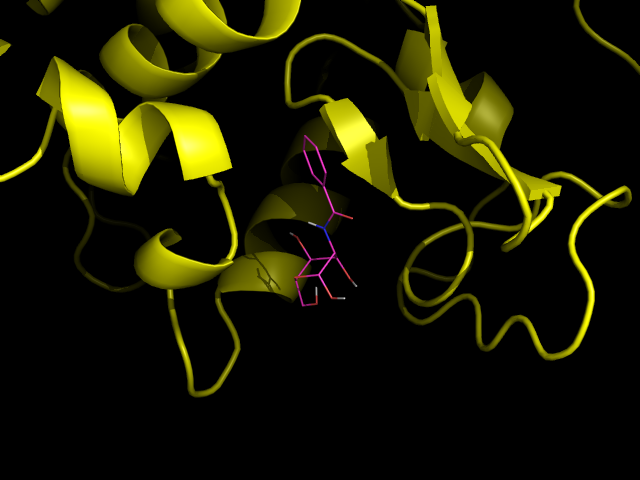

In [61]:
import __main__
__main__.pymol_argv = ['pymol','-qc'] # Pymol: quiet and no GUI
from time import sleep
import pymol
pymol.finish_launching()

#for index in [1,2,3]:
pymol.cmd.reinitialize()

pymol.cmd.load('r%d.pdb'%results.index.get_values()[0])
pymol.cmd.do('''
    load my_prot.pdb   
    show cartoon, my_prot
    hide lines, my_prot
    orient
    zoom r1, 9
    rotate x,150
    png pic0.png
''')
    # Desired pymol commands here to produce and save figures
sleep(2.5) # (in seconds)
Image(filename='pic0.png')

### Методы из статьи про ODDT, которые можно было бы использоватьв этом задании

C помощью oodt.virtualscreening можно было бы полностью провести докинг с помощью того же Autodock Vina.
А также можно было бы посчитать score докинга с помощью RFscore и NNscore.

#### <a href='Tikhonova. HW7.ipynb'> Download this notebook </a>